Code for the algorithms and functions test are available in the following files:

In [4]:
include("../optimizers/linesearch.jl")
include("../utils/functions.jl")
include("../utils/plot.jl")

using Gadfly

# Line Search algorithms

In this notebook, we'll review line search algorithms in general, specific
step lengths, and walk through a few examples.

## Overview

A line search algorithm is one that given a starting point $x_0$
produces iterates $x_{k+1}$ of the form:

$$x_{k+1} = x_k + \alpha_k p_k,$$

where $\alpha_k$ is the step length and $p_k$ is the step direction.
Let $f_k := f(x_k)$.

Ideally, we want an algorithm that both results in:

1. global convergence: i.e., the gradient norms converge to 0 
$$ || \nabla f_k || \rightarrow 0 \text{ as } k\rightarrow \infty$$

2. a fast rate of convergence 

In practice, we terminate when the values of the iterates ``stop changing", $||x_{k-1} - x_{k}|| < \epsilon$.
But we can also plot, e.g., 
1. the gradient norms $|| \nabla f_k ||$, to get a sense of global convergence, or 
2. the ratio of the gradient norms of the current and previous iterations $|| \nabla f_{k+1} ||/|| \nabla f_k ||$, to get a sense of the rate of convergence.

The two main important part are to choose the step length and the step direction.

## Choosing the step length $\alpha$

To choose the step length at iteration $k$, we could
choose $\alpha$ to minimize the value of the function $f(x_k + \alpha p_k)$, but we don't do this in practice because it is too expensive, even
though it's only a 1-dimensional line search.
Instead, we do what is called an _inexact line search_, where all we need
to do is produce an iterate $x_{k+1}$ that results in a sufficient reduction in the value of the function.

### Wolfe conditions 

In the inexact line search, we just need to make sure the step lengths
are not too long and not too short.
To do this, if the step length $\alpha$ satisfies two conditions,
known as the Wolfe conditions, then we can usually in praactice
do just as well as an exact line search.

The two conditions are the sufficient decrease condition and the
curvature requirement.
1. **Sufficient decrease (Armijo condition)**: 
$$ f(x_k + \alpha p_k) \leq f(x_k) + c_1 \alpha \nabla f_k^\top p_k.$$
2. **Curvature condition**:
$$ \nabla f(x_k + \alpha p_k)^\top p_k \geq c_2 \nabla f_k^\top p_k.$$

There's also a modified curvature condition, which together with the sufficient decrease condition is known as the _strong Wolfe conditions_, in which
$$ |\nabla f(x_k + \alpha p_k)^\top p_k| \leq c_2 |\nabla f_k^\top p_k|.$$

In both weak and strong cases, we require $0 < c_1 < c_2 < 1$.


In fact, we know that with some assumptions on the function, there always 
exist intervals of $\alpha$ for which the (weak or strong)
Wolfe conditions are always satisfied.



### Goldstein conditions

An alternative to the Wolfe conditions that also make sure step lengths are not too long or short are the Goldstien conditions.
They are
$$ f(x_k) +  (1-c) \alpha \nabla f_k^\top p_k \leq f(x_k + \alpha p_k) \leq f(x_k) +  c \alpha \nabla f_k^\top p_k,$$
where $c \in (0, \frac{1}{2})$.

Note that $\nabla f_k^\top p_k$ is the directional derivative. 

A downside of the Goldstein conditions is that they might exclude
all minimizers along $p_k$.



### Backtracking algorithm

An algorithm that works pretty well for picking $\alpha$ is the 
Armijo backtracking algorithm. 

Here we run this algorithm in every iteration to choose the specific
$\alpha_k$ we want to use.

We start with some initial value of $\alpha > 0$ (e.g., ideally some larger value that is too long) and then slowly decay the value of $\alpha$
until the Armijo sufficient decrease condition
$$ f(x_k + \alpha_k x_k) \leq f(x_k) + c_1 \alpha_k \nabla f_k^\top p_k$$
is satisfied.

More sophisticated inexact line searches that lead to faster convergence
based on, e.g., quadratic interpolation. 

We implement the basic backtracking algorithm for all line search algorithms described in this notebook.

## Step directions

We now describe several different types of step directions $p_k$,
which are what differentiates different named line search algorithms.

### Steepest descent

Here we just step in the direction of the gradient $p_k = -\nabla f(x_k)$.

### Newton's method

Here the step is $p_k = -\nabla^2 f(x_k)^{-1} \nabla f(x_k).$
This is the negative gradient multiplied by the exact Hessian. 

#### Indefinite Hessian corrections
If the Hessian $\nabla^2 f(x_k)^{-1}$ is not positive definite, then
$p_k$ is not a descent direction. 
If $f$ is not a convex function, then this will likely happen if we are not close enough to the optimal solution.

To account for this, we make a correction to the Hessian by adding a small multiple of the identity to the diagonal, trying small values until we get something sufficiently positive definite.

Other ways to correct for a non-positive definite Hessian include
a modified Cholesky factorizsation or modified indefinite factorization
method, but here we stick to the most basic type of method that is practical.

### Quasi-Newton methods

Here instead of computing the exact Hessian at each step, the Hessian is approximated with a matrix $B_k$ and updated in each iteration.

So, the descent direction is of the form
$$p_k = -B_k \nabla f(x_k),$$
where $B_k$ is a positive definite matrix.

Secant condition

#### BFGS

In the BFGS algorithm, the matrix $B_k$ is always positive definite,
so we don't have to worry about indefinite corrections.

The Armijo backtracking algorithm might result in step sizes with negative curvature. We can account for this by using a dampened BFGS algorithm.

### Inexact Newton methods and conjugate gradient

In Newton's method, we find the search direction $p_k$ by solving the linear system
$$\nabla^2 f_k p_k = -\nabla f_k.$$
Conjugate gradient methods can solve a large linear system inexpensively, and can be turned into a line search method.
We implement the Newton-CG method (aka truncated Newton method), in which we compute the search direction by applying the CG method to the above Newton equation and attempt to satisfy a termination test of the form
$$||r_k || \leq \eta_k ||\nabla f_k||,$$
where $r_k$ is the residual at step $k$ and $\eta_k \in (0,1)$.

## Convergence of line search algorithms

### Global convergence of line search algorithms

Zoutendijk's theorem tells us when we get global convergence in
line search algorithms.

In particular, it says that under the conditions
1. $f$ is continuously differentiable in an open set $N$ containing
$\{x : f(x) \leq f(x_0)\}$.
2. the gradient of $f$ is Lipschitz continuous on $N$, i.e., for all $x,x' \in N, ||\nabla f(x) - \nabla f(x')|| \leq L \,||x - x'||$.
3. $p_k$ is a descent direction, i.e., $\nabla f_k^\top p_k$
4. $\alpha_k$ satisfies the Wolfe conditions (or Goldstein conditions)
5. $f$ is bounded below in $\mathbb{R}^n$ (so it doesn't go off to $-\infty)$

that we have
$$ \sum_{k=0}^\infty ||\nabla f_k||^2 \cos^2(\theta_k) <\infty,$$
where $\theta_k$ is the the angle between the descent direction $p_k$
and the negative gradient $-\nabla_k$, which is also the steepest descent direction.
The angle is defined as:
$$\theta_k = \frac{ -\nabla f_k^\top p_k}{||\nabla f_k|| \, ||p_k||}.$$

This implies that $||f_k|| \rightarrow 0$ (global convergence) if the angle of the descent direction with the negative gradient (i.e., the direction of steepest descent) is bounded away from 90 degrees. 

**TL;DR:** any descent direction $p_k$ that is not too far away from the steepest descent direction leads to a globally convergent iteration.


### Rate of convergence


Though the steepest descent method is the "quintessential" globally 
convergent algorithms, in that the direction is the negative gradient
(i.e., the angle $\theta_k = 0$), it has a very slow rate of convergence (linear).
In constrast Newton's method and quasi-Newton methods have a much faster rate of convergence.

We'll see this in the example functions below -- we'll only plot the 
gradient norm ratios, which tell us whether we have linear or superlinear
convergence. If the ratios go to 0, then we have superlinear convergence.
(To see quadratic convergence, we'd look at the gradient norm divided by the square of the previous iteration's gradient norm. We don't plot this,
but we'll observe that Newton converges much faster than the other methods.)


Summary of convergence rates:
1. Steepest descent (linear)
2. Newton's method (quadratic)
3. Quasi-Newton (usually superlinear)
4. Conjugate gradient (superlinear)

# Testing the optimization methods 

In [12]:
# general function to plot the output of the algorithms
function plot_values(fx1, fx2, fx3, fx4, xlab, ylab, title)
    nsamps = length(fx1)
    nsamps2 = length(fx2)
    nsamps3 = length(fx3)
    nsamps4 = length(fx4)
    
    Gadfly.plot(layer(x=1:nsamps, y=fx1, Geom.line, 
        Theme(default_color=color("blue"))),
        layer(x=1:nsamps2, y=fx2, Geom.line, Theme(default_color=color("red"))),
        layer(x=1:nsamps3, y=fx3, Geom.line, Theme(default_color=color("orange"))),
        layer(x=1:nsamps4, y=fx4, Geom.line, Theme(default_color=color("purple"))),
        Guide.xlabel(xlab), Guide.ylabel(ylab), 
        Guide.title(title),
        Guide.manual_color_key("Legend", 
            ["Newton", "steepest", "Newton-CG", "BFGS"], 
            ["blue", "red", "orange", "purple"]),
        Scale.x_log10, Scale.y_log10)
end

plot_values (generic function with 1 method)

## Fenton's function

In [5]:
@time xvals = line_search(fenton, [3.;4.], 
    fenton_g, fenton_h, "newton", 1000);
@time svals = line_search(fenton, [3.;4.], 
    fenton_g, fenton_h, "steepest", 1000);
@time cvals = line_search(fenton, [3.;4.], 
    fenton_g, fenton_h, "newton_CG", 1000);
@time qvals = line_search(fenton, [3.;4.], 
    fenton_g, fenton_h, "BFGS", 1000);

Using method newton
Number of indefinite fixes 0
Number of iterations 7
  2.345913 seconds (1.72 M allocations: 78.202 MB, 1.18% gc time)
Using method steepest
100
200
300
Number of indefinite fixes 0
Number of iterations 376
  0.034531 seconds (42.26 k allocations: 1.353 MB)
Using method newton_CG
Number of indefinite fixes 0
Number of iterations 10
  0.806269 seconds (1.02 M allocations: 45.587 MB, 1.53% gc time)
Using method BFGS
Number of indefinite fixes 0
Number of iterations 13
  0.116728 seconds (91.09 k allocations: 3.965 MB)


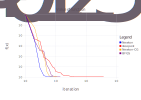

In [7]:
nsamps = length(xvals)
nsamps2 = length(svals)
nsamps3 = length(cvals)
nsamps4 = length(qvals)


fx = [fenton(xvals[i]) for i in 1:nsamps]
fx2 = [fenton(svals[i]) for i in 1:nsamps2]
fx3 = [fenton(cvals[i]) for i in 1:nsamps3]
fx4 = [fenton(qvals[i]) for i in 1:nsamps4]

plot_values(fx, fx2, fx3, fx4, "iteration", "f(x)", "Value of function")

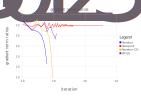

In [9]:
grads = [norm(fenton_g(xvals[i]), 2) for i in 1:nsamps]
grads2 = [norm(fenton_g(svals[i]), 2) for i in 1:nsamps2]
grads3 = [norm(fenton_g(cvals[i]), 2) for i in 1:nsamps3]
grads4 = [norm(fenton_g(qvals[i]), 2) for i in 1:nsamps4]

r1 = compute_grad_ratio(grads)
r2 = compute_grad_ratio(grads2)
r3 = compute_grad_ratio(grads3)
r4 = compute_grad_ratio(grads4)

plot_values(r1, r2, r3, r4, "iteration", 
    "gradient norm ratios", "gradient norm ratios")

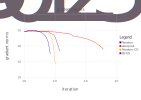

In [10]:
plot_values(grads, grads2, grads3, grads4, "iteration", 
    "gradient norms", "gradient norms")

## Rosenbrock function

The Rosenbrock function is defined by:
$$f(x) = \sum_{i=1}^n [ (1-x_{2i-1})^2 + 10(x_{2i} - x_{2i-1}^2)^2 ]$$


In [13]:
@time xvals = line_search(rosenbrock, ones(100)*3, rosenbrock_g, rosenbrock_h, 
    "newton", 2000, 1e-8);
@time svals = line_search(rosenbrock, ones(100)*3, rosenbrock_g, rosenbrock_h, 
    "steepest", 5000, 1e-8);
@time cvals = line_search(rosenbrock, ones(100)*3, rosenbrock_g, rosenbrock_h, 
    "newton_CG", 2000, 1e-8);
@time qvals = line_search(rosenbrock, ones(100)*3, rosenbrock_g, rosenbrock_h, 
    "BFGS", 2000, 1e-8);

Using method newton
Number of indefinite fixes 0
Number of iterations 12
  3.791919 seconds (49.75 M allocations: 767.828 MB, 5.08% gc time)
Using method steepest
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
Number of indefinite fixes 0
Number of iterations 3064
 11.670348 seconds (144.08 M allocations: 2.444 GB, 2.82% gc time)
Using method newton_CG
Number of indefinite fixes 0
Number of iterations 15
  4.140566 seconds (62.13 M allocations: 957.349 MB, 2.32% gc time)
Using method BFGS
Number of indefinite fixes 0
Number of iterations 43
  0.470065 seconds (6.73 M allocations: 139.479 MB, 3.37% gc time)


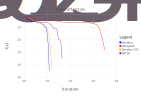

In [15]:
func = rosenbrock
func_g = rosenbrock_g

nsamps = length(xvals)
nsamps2 = length(svals)
nsamps3 = length(cvals)
nsamps4 = length(qvals)


fx = [func(xvals[i]) for i in 1:nsamps]
fx2 = [func(svals[i]) for i in 1:nsamps2]
fx3 = [func(cvals[i]) for i in 1:nsamps3]
fx4 = [func(qvals[i]) for i in 1:nsamps4]

plot_values(fx, fx2, fx3, fx4, "iteration", "f(x)", "Value of function")

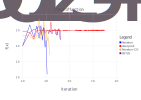

In [17]:
nsamps = length(xvals)

grads = [norm(func_g(xvals[i]), 2) for i in 1:nsamps]
grads2 = [norm(func_g(svals[i]), 2) for i in 1:nsamps2]
grads3 = [norm(func_g(cvals[i]), 2) for i in 1:nsamps3]
grads4 = [norm(func_g(qvals[i]), 2) for i in 1:nsamps4]

r1 = compute_grad_ratio(grads)
r2 = compute_grad_ratio(grads2)
r3 = compute_grad_ratio(grads3)
r4 = compute_grad_ratio(grads4)

plot_values(r1, r2, r3, r4, "iteration", "gradient norm ratios", 
    "gradient norm ratios")

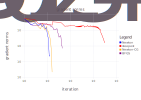

In [19]:
plot_values(grads, grads2, grads3, grads4, "iteration", "gradient norms", 
    "gradient norms")

## Cute function

The cute function is given by $f: \mathbb{R}^n \rightarrow \mathbb{R}$
$$ f(x) = \sum_{i=1}^{n-4} (-4x_i+3)^2 + (x_i^2 + 2x_{i+1}^2 + 3x_{i+2}^2 + 4 x_{i+3}^2 + 5x_n^2)^2 $$

In [20]:
@time xvals = line_search(cute, ones(100)*10, cute_g, cute_h, "newton", 
    2000, 1e-8);
@time svals = line_search(cute, ones(100)*10, cute_g, cute_h, "steepest", 
    2000, 1e-8);
@time cvals = line_search(cute, ones(100)*10, cute_g, cute_h, "newton_CG", 
    2000, 1e-8);
@time qvals = line_search(cute, ones(100)*10, cute_g, cute_h, "BFGS", 
    2000, 1e-8);

Using method newton
Number of indefinite fixes 0
Number of iterations 16
 16.224665 seconds (126.05 M allocations: 1.889 GB, 3.86% gc time)
Using method steepest
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Finished algorithm without converging.
 26.568222 seconds (187.94 M allocations: 3.078 GB, 5.12% gc time)
Using method newton_CG
Number of indefinite fixes 0
Number of iterations 21
 20.689629 seconds (165.43 M allocations: 2.483 GB, 3.66% gc time)
Using method BFGS
100
Number of indefinite fixes 0

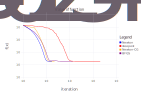


Number of iterations 131
  2.744460 seconds (23.09 M allocations: 464.262 MB, 3.43% gc time)


In [21]:
func = cute
func_g = cute_g

nsamps = length(xvals)
nsamps2 = length(svals)
nsamps3 = length(cvals)
nsamps4 = length(qvals)

fx = [func(xvals[i]) for i in 1:nsamps]
fx2 = [func(svals[i]) for i in 1:nsamps2]
fx3 = [func(cvals[i]) for i in 1:nsamps3]
fx4 = [func(qvals[i]) for i in 1:nsamps4]


plot_values(fx, fx2, fx3, fx4, "iteration", "f(x)", "Value of function")

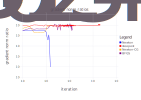

In [22]:
grads = [norm(func_g(xvals[i]), 2) for i in 1:nsamps]
grads2 = [norm(func_g(svals[i]), 2) for i in 1:nsamps2]
grads3 = [norm(func(cvals[i]), 2) for i in 1:nsamps3]
grads4 = [norm(func_g(qvals[i]), 2) for i in 1:nsamps4]

r1 = compute_grad_ratio(grads)
r2 = compute_grad_ratio(grads2)
r3 = compute_grad_ratio(grads3)
r4 = compute_grad_ratio(grads4)

plot_values(r1, r2, r3, r4, "iteration", "gradient norm ratio", 
    "gradient norm ratios")

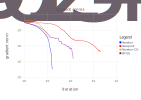

In [23]:
plot_values(grads, grads2, grads3, grads4, "iteration", "gradient norm", 
    "gradient norms")